In [1]:
from model import SegmentationModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SegmentationModel()
model.to(device)

print(model)

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
SegmentationModel(
  (model): SimpleSegNet(
    (enc1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (enc2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (enc3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (bottleneck): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

In [2]:
import torchvision.transforms as T
from PIL import Image

img_path = "./dataset/train2014/COCO_train2014_000000000009.jpg"


img = Image.open(img_path).convert("RGB")
transform = T.Compose(
    [
        T.Resize((512, 512)),
        T.ToTensor(),
    ]
)
img_to_tensor = transform(img).unsqueeze(0).to(device)


In [ ]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity

model = SegmentationModel().to(device)
model.eval()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             record_shapes=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            _ = model(img_to_tensor)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.46%     587.338us        99.76%     126.029ms     126.029ms       0.000us         0.00%     261.686ms     261.686ms             1  
                                      aten::convolution         0.03%      39.037us        95.67%     120.869ms      13.430ms       0.000us         0.00%     252.015ms      28.002ms             9  
         

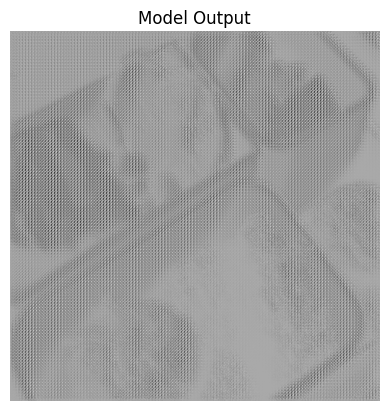

In [6]:
import matplotlib.pyplot as plt

with torch.no_grad():
    output = model(img_to_tensor)
    output_img = output.squeeze().cpu().numpy()

plt.imshow(output_img, cmap="gray")
plt.title("Model Output")
plt.axis("off")
plt.show()